<a href="https://colab.research.google.com/github/taareek/osteo-application/blob/main/web_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sample_img_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset/Non-Tumor/Case-3-A10-10547-25283.jpg"

In [ ]:
# load an input image
from PIL import Image
image = Image.open(sample_img_path)

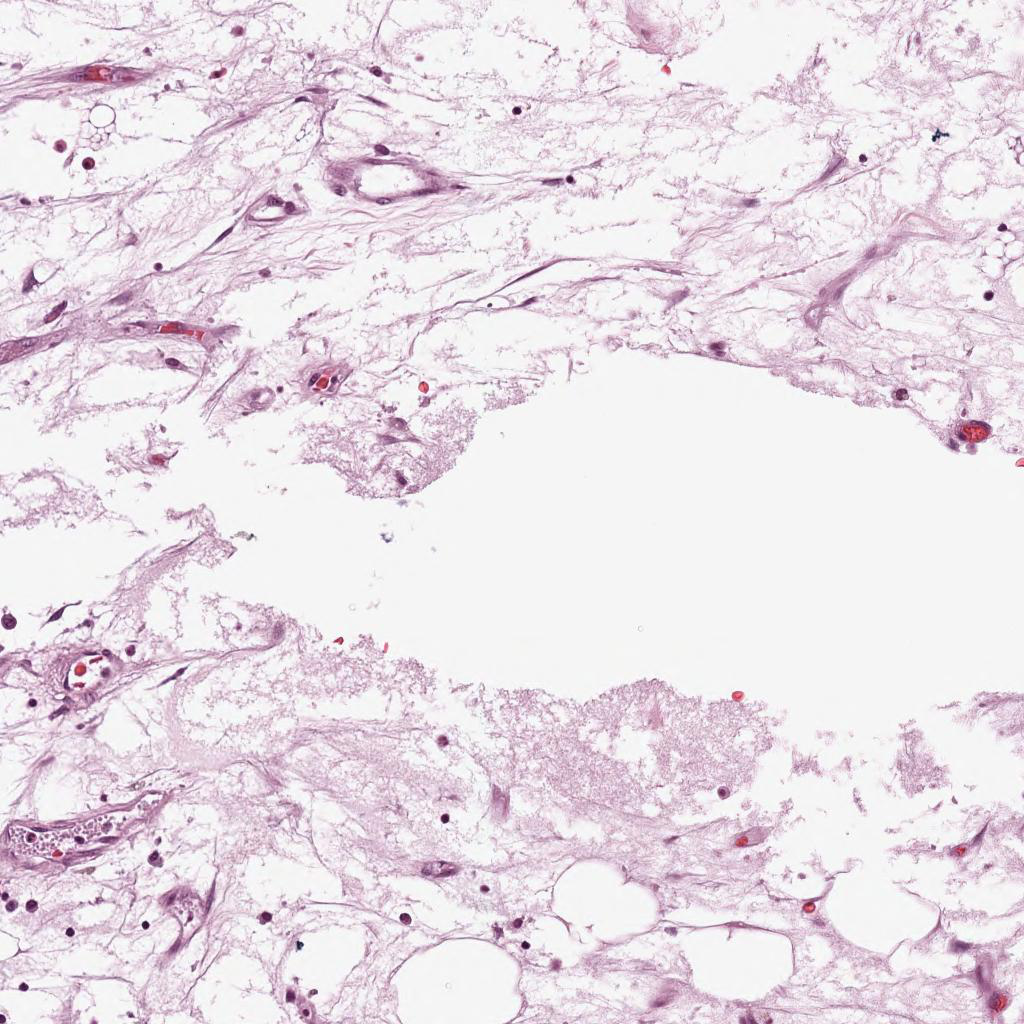

In [ ]:
image

In [ ]:
# applying transformation on input image 
# resize, torch, normalization

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
        ])

In [ ]:
img = data_transforms(image)

In [ ]:
# print(type(img))
# print("Shape of image: ", img.shape)

In [ ]:
# function to visualize transformed image
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

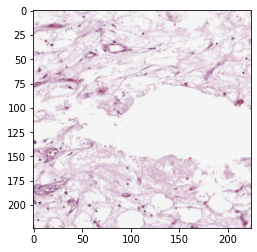

In [ ]:
imshow(img)

# train CNN for 1024 features that can be loaded during feature extraction

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# declaring image folder path
data_path = '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset'

# loading dataset
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= data_transforms)

print("total samples in dataset: ", len(dataset))

num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)
# image classes
# classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

total samples in dataset:  1144
After splitting train data:  916
After splitting test data:  228


**loading pre-trained model**

In [ ]:
# Taking Densenet 121 model 
from torchvision import models
densenet_121 = models.densenet121(pretrained= True)

In [ ]:
import torch.nn as nn

# freexing layers to use pre-trained weights
model = models.densenet121(pretrained=True)
for param in model.parameters():
        param.requires_grad = False

# we will extract 1024 features from densnet pre trained model
model.classifier = nn.Linear(1024, 1024)

# demo
x = torch.rand(4, 3, 224, 224)
out = model.forward(x)
print(out.shape)

torch.Size([4, 1024])


In [ ]:
# taking model into GPU
if torch.cuda.is_available():
  model.cuda()

In [ ]:
# optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.8 ) #weight_decay= 5e-4  # 0.9->momentum
# optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001, betas= (0.9, 0.999), eps= 1e-8, weight_decay=0)
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# number of epochs to train the model
n_epochs = 15

# using test set as validation set
valid_loader = test_loader

valid_loss_min = np.Inf # track change in validation loss

valid_list= []  # stores validation losses
train_list= []  # stores train losses

valid_acc = [] # store validation accuracy
train_acc = [] # store train accuracy

for epoch in range(1, n_epochs+1):

    # keep track of training, validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_corrects = 0
    val_corrects = 0

    # trianing the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        _,preds = torch.max(output, 1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_corrects += torch.sum(preds == target.data)
        
          
    # validate the model 
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        _,preds = torch.max(output, 1)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        val_corrects += torch.sum(preds == target.data) 
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    # calculate accuracy
    t_acc = train_corrects/len(train_loader.sampler)
    v_acc = val_corrects/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTrain Acc: {:4f} \tValidation Acc: {:4f}'.format(
        epoch, train_loss, valid_loss, t_acc, v_acc))
    
    # Using Schedular step
    # scheduler.step()
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/web_app_1024.pt')
        valid_loss_min = valid_loss
    
    #storing train and validation looses
    train_list.append(train_loss)
    valid_list.append(valid_loss)
    # storing train and validartion accuracy
    train_acc.append(t_acc)
    valid_acc.append(v_acc)

# keep Best accuracy and try again
# train as out features 1024

Epoch: 1 	Training Loss: 1.791649 	Validation Loss: 0.594685 	Train Acc: 0.613537 	Validation Acc: 0.833333
Validation loss decreased (inf --> 0.594685).  Saving model ...
Epoch: 2 	Training Loss: 0.511834 	Validation Loss: 0.471778 	Train Acc: 0.850437 	Validation Acc: 0.850877
Validation loss decreased (0.594685 --> 0.471778).  Saving model ...
Epoch: 3 	Training Loss: 0.423128 	Validation Loss: 0.364093 	Train Acc: 0.875546 	Validation Acc: 0.890351
Validation loss decreased (0.471778 --> 0.364093).  Saving model ...
Epoch: 4 	Training Loss: 0.400026 	Validation Loss: 0.341004 	Train Acc: 0.864629 	Validation Acc: 0.868421
Validation loss decreased (0.364093 --> 0.341004).  Saving model ...
Epoch: 5 	Training Loss: 0.346959 	Validation Loss: 0.312004 	Train Acc: 0.890830 	Validation Acc: 0.885965
Validation loss decreased (0.341004 --> 0.312004).  Saving model ...
Epoch: 6 	Training Loss: 0.318207 	Validation Loss: 0.304838 	Train Acc: 0.901747 	Validation Acc: 0.894737
Validation l

# Combining CNN and ML

In [ ]:
# taking our dataset 
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# declaring image folder path
data_path = '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset'

In [ ]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("total samples in dataset: ", len(dataset))

total samples in dataset:  1144


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['Non-Tumor', 'Necrosis', 'Viable']

After splitting train data:  916
After splitting test data:  228


**Taking pretrained DenSenet-121**

In [ ]:
# Another way
# this way crash 
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
# DEFAULT weights give us best available weights 
weights = DenseNet121_Weights.DEFAULT   # try  IMAGENET1K_V1 too to compare performance 
model = densenet121(weights= weights)

# we will extract 1024 features from densnet pre trained model
model.classifier = nn.Linear(1024, 1024)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/web_app_1024.pt', map_location=torch.device('cpu')))

In [ ]:
if torch.cuda.is_available():
  model.cuda()

In [ ]:
# feature extraction for training images

x_train = []
y_train = []
model.eval()
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    x_train.append(output)

    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')
    target = target.numpy()
    target = target.astype(int)
    y_train.append(target)

<ipython-input-14-61d044751d11>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, device= 'cpu')


In [ ]:
# feature extraction for test images 

x_test = []
y_test = []
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    x_test.append(output)

    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')

    target = target.numpy()
    target = target.astype(int)
    y_test.append(target)

<ipython-input-15-098f06b7e289>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, device= 'cpu')


In [ ]:
# As we are getting data from dataloader, so data are inserted as batch size
# that's why we need to convert this into 1D list 
from itertools import chain
x_train_features = list(chain.from_iterable(x_train))
x_test_features = list(chain.from_iterable(x_test))

print("Total training features: ", len(x_train_features))
print("Total test features: ", len(x_test_features))

Total training features:  916
Total test features:  228


In [ ]:
# converting labels into one dimensional list 
y_train = list(chain.from_iterable(y_train))
y_test = list(chain.from_iterable(y_test))

print("Total training labels: ", len(y_train))
print("Total test labels: ", len(y_test))

Total training labels:  916
Total test labels:  228


In [ ]:
type(x_train_features[99])

torch.Tensor

In [ ]:
for i in range(len(x_train_features)):
    # x_train_features[i] = x_train_features[i].numpy()
    if torch.cuda.is_available():
        x_train_features[i] = x_train_features[i].cpu().detach().numpy()   # if use GPU
    else:
      x_train_features[i] = x_train_features[i].detach().numpy()  

#converting list to numpy array
x_train_features = np.array(x_train_features)
print("Shape of training features: ",x_train_features.shape)

Shape of training features:  (916, 1024)


In [ ]:
for i in range(len(x_test_features)):
    # x_test_features[i] = x_test_features[i].numpy()
    if torch.cuda.is_available():
        x_test_features[i] = x_test_features[i].cpu().detach().numpy()
    else:
      x_test_features[i] = x_test_features[i].detach().numpy()

# converting list to numpy array
x_test_features = np.array(x_test_features)
print("Shape of test features: ",x_test_features.shape)

Shape of test features:  (228, 1024)


In [ ]:
#Convert label lists to arrays                
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shape of training labels: ", y_train.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training labels:  (916,)
Shape of test labels:  (228,)


In [ ]:
# making a dataframe from the train features
import pandas as pd
df = pd.DataFrame(x_train_features)
df = df.assign(labels= y_train)
df.head()
# saving csv to local machine
# df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_multiclass.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,13.690207,8.552003,9.684608,-0.198925,0.557237,0.602062,-0.176342,-0.140473,0.382840,-0.062363,...,-0.346820,0.471806,0.506790,-0.653003,0.390981,0.361036,-0.673440,-0.091378,-0.161185,0
1,12.074905,7.839459,7.344232,-0.325138,0.238677,-0.286629,0.345394,0.445007,-0.291963,0.049928,...,0.201333,0.027623,-0.120017,-0.587637,0.288183,0.483806,0.139223,0.059201,-0.116579,0
2,16.014891,12.639116,13.485518,-0.696040,0.154974,0.589222,-0.113722,-0.012080,-0.118027,0.266284,...,-0.273758,-0.019143,-0.164362,-0.846552,0.197583,0.895778,0.033388,-0.066300,-0.369965,0
3,8.620357,13.871183,10.000701,-0.822872,0.139339,0.391690,0.144432,0.201328,-0.186427,0.417527,...,-0.189819,0.052753,0.623428,-0.784192,-0.060192,-0.027619,-0.110846,-0.383237,-0.274806,1
4,12.264392,13.844898,14.991847,-0.443155,0.991070,0.773525,-0.038560,0.256745,-0.322685,0.163565,...,0.060131,-0.269833,0.539183,-0.761751,-0.370341,0.793554,-0.444893,-0.250627,-0.267312,2


In [ ]:
df['labels']

0      0
1      0
2      0
3      1
4      2
      ..
911    1
912    0
913    1
914    1
915    0
Name: labels, Length: 916, dtype: int64

In [ ]:
# getting information about train features
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
count,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,...,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000
mean,12.867601,11.511015,12.078296,-0.671160,0.414301,0.262750,0.052835,0.011075,0.014948,0.197061,...,-0.286675,0.001584,0.134435,-0.723780,0.189900,0.435838,-0.121107,-0.155396,-0.128415,0.830786
std,2.890415,2.434665,3.064722,0.380175,0.334066,0.317713,0.316431,0.306710,0.281166,0.324538,...,0.291313,0.297364,0.357256,0.356647,0.350513,0.343631,0.298030,0.350423,0.338093,0.858752
min,4.616529,5.173123,4.668758,-1.962564,-0.619206,-0.591423,-0.855583,-1.114285,-0.820741,-0.873216,...,-1.341942,-0.976356,-1.050271,-1.907145,-0.810661,-0.595659,-1.005599,-1.239453,-1.326040,0.000000
25%,10.775024,9.674760,9.953449,-0.932656,0.177726,0.053863,-0.167722,-0.181752,-0.175826,-0.023874,...,-0.480699,-0.184679,-0.121446,-0.974298,-0.059088,0.205909,-0.322108,-0.406141,-0.348663,0.000000
50%,13.015768,11.290553,11.469951,-0.667106,0.410890,0.259109,0.045474,0.022209,0.024097,0.184640,...,-0.291797,0.002803,0.148703,-0.736379,0.176683,0.444121,-0.119269,-0.161449,-0.132451,1.000000
75%,14.974533,13.229072,13.810331,-0.417688,0.633166,0.472910,0.246278,0.207619,0.210532,0.388895,...,-0.086287,0.201317,0.385379,-0.486443,0.403429,0.689443,0.085162,0.092227,0.093795,2.000000
max,21.256479,19.005966,22.703493,0.404092,1.508605,1.339332,1.404552,1.127630,0.974451,1.481229,...,0.642184,0.881077,1.272013,0.275963,1.470499,1.540360,0.743779,0.887102,1.050174,2.000000


In [ ]:
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_multiclass.csv', index=False)

In [ ]:
# making a dataframe from the train features
df_test = pd.DataFrame(x_test_features)
df_test = df_test.assign(labels= y_test)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,15.825315,10.306439,11.718665,-0.298338,0.329904,0.183944,0.090307,-0.215201,0.420112,0.169051,...,-0.338165,0.091186,0.031015,-1.076291,-0.099305,0.483048,-0.649289,-0.157292,0.067398,0
1,13.704435,12.496385,10.025866,-1.292318,0.105427,0.864614,0.225867,-0.174044,-0.145173,0.492365,...,-0.225965,0.477347,0.718746,-0.685970,0.340760,0.180604,-0.758172,0.041689,-0.003373,0
2,12.517220,11.392244,15.698396,-0.828764,-0.200315,0.603234,-0.215518,-0.665848,-0.699036,0.124940,...,-0.468743,-0.170194,0.270859,-0.545093,-0.004356,0.243987,-0.340357,0.095177,-0.750376,2
3,10.215495,14.840645,10.715829,-0.481330,0.196009,0.549675,-0.270746,-0.210771,0.433116,0.568143,...,-0.368461,0.114260,0.161707,-0.322675,0.050537,0.336350,-0.429526,-0.622057,0.443539,1
4,11.436803,13.606157,11.577913,-0.200010,0.446637,-0.059067,0.470938,-0.769523,-0.134714,0.603275,...,-0.527082,0.228360,0.193140,-0.805566,-0.201315,-0.299902,-0.921351,-0.532124,-0.514670,2


In [ ]:
# getting information about train features
df_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,...,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,12.727424,11.410589,11.951753,-0.644615,0.411741,0.242048,0.061237,-0.011887,-0.016129,0.150128,...,-0.322844,-0.014472,0.122505,-0.717044,0.176927,0.388585,-0.140140,-0.172898,-0.124071,0.837719
std,2.949298,2.130609,3.082519,0.357578,0.340639,0.353205,0.313353,0.322280,0.274648,0.328469,...,0.295103,0.324383,0.326669,0.364240,0.349682,0.342529,0.314760,0.348599,0.319705,0.878012
min,5.057600,5.965013,5.476453,-1.538316,-0.509860,-0.658201,-1.044791,-0.909784,-0.699036,-0.667080,...,-1.095154,-0.923879,-0.625176,-1.790193,-0.632099,-0.391806,-0.921351,-1.120362,-1.146040,0.000000
25%,10.654458,10.033023,9.748533,-0.894659,0.181840,-0.014415,-0.149698,-0.219074,-0.179278,-0.079350,...,-0.516883,-0.235765,-0.097336,-0.949427,-0.067315,0.138078,-0.349119,-0.429321,-0.330799,0.000000
50%,12.801330,11.569053,11.614028,-0.662715,0.408651,0.240338,0.028880,-0.046137,-0.030085,0.140585,...,-0.310241,-0.013451,0.122825,-0.756502,0.180136,0.390493,-0.125005,-0.170520,-0.152696,1.000000
75%,14.884134,12.865142,13.605347,-0.402655,0.613873,0.481165,0.277827,0.212833,0.167156,0.397693,...,-0.114152,0.210541,0.346742,-0.463816,0.408366,0.651602,0.079596,0.078347,0.073026,2.000000
max,19.434399,16.348354,20.411127,0.363120,1.309835,1.389054,0.874922,0.916323,0.806490,1.044777,...,0.526776,1.059727,1.074086,0.312670,1.248777,1.295633,0.620929,0.714463,0.766318,2.000000


In [ ]:
# saving dataframe to local machine
df_test.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/test_multiclass.csv', index=False)

In [ ]:
# Feature scaling 
# Scaling train and test features
import pickle
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train_features)
X_test = sc.transform(x_test_features)


print("After scaling train: ", X_train.shape)
print("After scaling test size: ", X_test.shape)

# save feature scaler as pickle
# pickle_out = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/feat_scaling.pkl", "wb")
# pickle.dump(sc, pickle_out)
# pickle_out.close()

After scaling train:  (916, 1024)
After scaling test size:  (228, 1024)


### Integrating ML

In [ ]:
import pandas as pd
import numpy as np

# load train features 
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_multiclass.csv')

# load test features 
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/test_multiclass.csv')

In [ ]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,15.825314,10.306439,11.718665,-0.298338,0.329904,0.183944,0.090307,-0.215201,0.420112,0.169051,...,-0.338165,0.091186,0.031015,-1.076291,-0.099305,0.483048,-0.649289,-0.157292,0.067398,0
1,13.704435,12.496385,10.025866,-1.292318,0.105427,0.864614,0.225867,-0.174044,-0.145173,0.492365,...,-0.225965,0.477347,0.718746,-0.685971,0.340760,0.180604,-0.758172,0.041689,-0.003373,0
2,12.517220,11.392244,15.698396,-0.828764,-0.200315,0.603234,-0.215518,-0.665848,-0.699036,0.124940,...,-0.468743,-0.170194,0.270859,-0.545093,-0.004356,0.243987,-0.340357,0.095177,-0.750376,2
3,10.215495,14.840645,10.715829,-0.481330,0.196009,0.549675,-0.270746,-0.210771,0.433116,0.568143,...,-0.368461,0.114260,0.161707,-0.322675,0.050537,0.336350,-0.429526,-0.622057,0.443539,1
4,11.436803,13.606157,11.577913,-0.200010,0.446637,-0.059067,0.470938,-0.769523,-0.134714,0.603275,...,-0.527082,0.228360,0.193140,-0.805566,-0.201315,-0.299902,-0.921351,-0.532124,-0.514670,2


In [ ]:
# taking features 
x_train_features = train_data.drop(['labels'], axis= 1).values
print("train features shape: ", x_train_features.shape)
# x_train_features = x_train_features.values
print(f"type of x_train features: {type(x_train_features)}")
# taking labels
y_train = train_data.labels.values
# y_train = y_train.values
print("train labels: ", y_train.shape)
print(f"type of labels: {type(y_train)}")

# taking test features 
x_test_features = test_data.drop(['labels'], axis=1).values
print(f"test features shape: {x_test_features.shape}")
# taking y_train
y_test = test_data.labels.values
print(f"test labels: {y_test.shape}")

train features shape:  (916, 1024)
type of x_train features: <class 'numpy.ndarray'>
train labels:  (916,)
type of labels: <class 'numpy.ndarray'>
test features shape: (228, 1024)
test labels: (228,)


In [ ]:
# creating a pickle file for using serialization
import pickle

# Without feature selection
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(x_train_features, y_train)

# predicting through test data
mlp_pred = mlp_classifier.predict(x_test_features)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))
# plot roc curve 
# change class names non-viable to necrosis

# save the classifier as pickle
pickle_out = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/without_fs_mlp.pkl", "wb")
pickle.dump(mlp_classifier, pickle_out)
pickle_out.close()

Accuracy =  0.939
ROC-AUC score is:  0.991


In [ ]:
# use score 
train_acc = mlp_classifier.score(x_train_features, y_train)
test_acc = mlp_classifier.score(x_test_features, y_test)
print("Training Accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training Accuracy:  1.0
Test accuracy:  0.9385964912280702


In [ ]:
# # Without feature selection
# from sklearn.neural_network import MLPClassifier

# # defining MLP classifier
# mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# # fitting training data 
# mlp_classifier.fit(X_train, y_train)

# # predicting through test data
# mlp_pred = mlp_classifier.predict(X_test)

# #Print overall accuracy
# from sklearn import metrics
# acc = metrics.accuracy_score(y_test, mlp_pred)
# print ("Accuracy = ", round(acc, 3))

Accuracy =  0.908


In [ ]:
# # use score 
# train_acc = mlp_classifier.score(X_train, y_train)
# test_acc = mlp_classifier.score(X_test, y_test)
# print("Training Accuracy: ", train_acc)
# print("Test accuracy: ", test_acc)

Training Accuracy:  1.0
Test accuracy:  0.9078947368421053


In [ ]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize= False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        title = "Normalized Confusion Matrix"
    else:
        # print('Confusion matrix, without normalization')
        title = "Confusion Matrix"

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

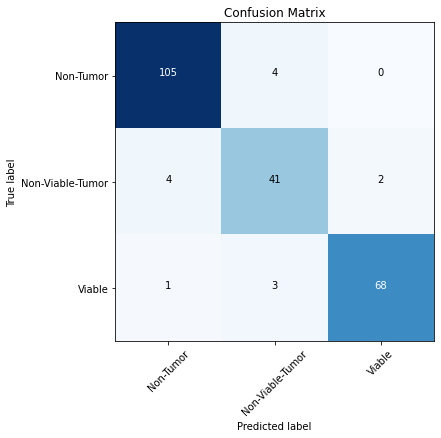

In [ ]:
# image classes
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, mlp_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

In [ ]:
# if we don't convert into numpy 
# t = x_test_features.loc[1]
# t

In [ ]:
# print(type(t))
# t = np.array(t)
# print(type(t))
# print(t.shape)
# t= t.reshape(1, -1)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1024,)


In [ ]:
# for a single image 
d_sample = x_test_features[1].reshape(1,-1)
# d_sample = (np.array(x_test_features.loc[1])).reshape(1,-1)
print(d_sample.shape)
d_predict = mlp_classifier.predict(d_sample)
print("Predicted label: ", d_predict)

# predict proba
d_pred_proba = mlp_classifier.predict_proba(d_sample)
print("Predicted probability: ", d_pred_proba)

# predict log probability
d_log = mlp_classifier.predict_log_proba(d_sample)
print("Predicted log probability: ", d_log)

(1, 1024)
Predicted label:  [0]
Predicted probability:  [[0.99661964 0.00206244 0.00131792]]
Predicted log probability:  [[-3.38608342e-03 -6.18386504e+00 -6.63170352e+00]]


In [ ]:
np.sum(d_pred_proba)
ff = np.argmax(d_pred_proba, axis=1)
print("Index: ",ff)
print("Probability value: ",d_pred_proba[0][ff])
cls_prob = d_pred_proba[0][ff] * 100
a = cls_prob[0]
print("getting single value: ", a)
format_float = "{:.3f}".format(a)
print("{:.3f}".format(a), "%")

####
print("{:.3f}".format(np.max(d_pred_proba)*100), "%")

Index:  [0]
Probability value:  [0.99661964]
getting single value:  99.66196429001117
99.662 %
99.662 %


**Using Saved MLP Classifier**

In [ ]:
# getting pickle file 
classifier_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/without_fs_mlp.pkl"
# feat_scaler_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/feat_scaling.pkl"

pickle_in = open(classifier_path, "rb")
classifier = pickle.load(pickle_in)

# pickle_he = open(feat_scaler_path, "rb")
# f_scaler = pickle.load(pickle_he)

In [ ]:
# perform feature scaling
# s_feature = f_scaler.transform(d_sample)

In [ ]:
# predict using loaded classifier 
# cls_prediction = classifier.predict(s_feature)
cls_prediction = classifier.predict(d_sample)

In [ ]:
# predict proba
# d_pred_proba = classifier.predict_proba(s_feature)
d_pred_proba = classifier.predict_proba(d_sample)
print("Predicted probability: ", d_pred_proba)

print(np.max(d_pred_proba) *100, "%")

Predicted probability:  [[0.99661964 0.00206244 0.00131792]]
99.66196429001117 %


In [ ]:
cls_prediction

array([0])

In [ ]:
# for all test features
cls_prediction = classifier.predict(x_test_features)
cls_prediction 

array([0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1, 0,
       2, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 2, 2, 2, 0, 0,
       1, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0,
       0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0,
       0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2,
       0, 1, 1, 2, 2, 2, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0,
       1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 1, 0, 2, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 2])

In [ ]:
acc = metrics.accuracy_score(y_test, cls_prediction)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.939


In [ ]:
# print(x_test_features.shape)
# print(x_test_features.shape[1])

(228, 1024)
1024


In [ ]:
r = x_test_features[1].reshape(1,-1)
print(r.shape)

(1, 1024)


In [ ]:
single_pred = classifier.predict(r)

In [ ]:
print(single_pred)
print(type(single_pred))

[0]
<class 'numpy.ndarray'>


In [ ]:
# t = single_pred.astype(int)
t = np.int_(single_pred)
print(t[0], type(t))

0 <class 'numpy.ndarray'>


In [ ]:
print(classes[single_pred[0]]) # as it has only one element 

Non-Tumor


In [ ]:
# compared to ture label
test_data.loc[1].labels

0.0

**MLP with RFE**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=900)

# fit our train data into RFE 
rfe.fit(x_train_features, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(x_train_features)

# getting transformed test features
X_test_rfe = rfe.transform(x_test_features)

print("After applying RFE, shape for train data: ", X_train_rfe.shape)
print("After applying RFE, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# save the feature selector as pickle
pickle_out_rfe = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_multiclass_rfe.pkl", "wb")
pickle.dump(rfe, pickle_out_rfe)
pickle_out_rfe.close()

# save the classifier as pickle
pickle_out_mlp = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/multiclass_rfe_mlp.pkl", "wb")
pickle.dump(mlp_rfe, pickle_out_mlp)
pickle_out_mlp.close()

After applying RFE, shape for train data:  (916, 900)
After applying RFE, shape for test data:  (228, 900)
k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.939
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.902


**taking saved feature selection and classifier to predict data**

In [ ]:
# getting classifiers pickle file 
new_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/multiclass_rfe_mlp.pkl"
pickle_in = open(new_cls_path, "rb")
new_classifier = pickle.load(pickle_in)

# getting feature selection pickle file
feats_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_multiclass_rfe.pkl"
feats_in = open(feats_path, "rb")
feater_selector = pickle.load(feats_in)

In [ ]:
# feature selection using loaded feature selector
selected_test_feat = feater_selector.transform(x_test_features)
print(selected_test_feat.shape)

# predict using loaded classifier 
sel_pred = new_classifier.predict(selected_test_feat)
# d_pred = new_classifier.predict(x_test_features)


(228, 900)


In [ ]:
acc = metrics.accuracy_score(y_test, sel_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.939


**now we will see prediction for a single image input**

In [5]:
from PIL import Image
img_1  ="/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset/Viable/Case-3-A12-37374-17669.jpg"
img_2 = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset/Viable/Case-4-C21-20675-9095.jpg"
# img_1 = Image.open(img_1)
# img_2 = Image.open(img_2)

In [6]:
# applying transformation on input image (resize, torch, normalization)
def image_transformation(input_img):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

    data_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
            ])
    image = Image.open(input_img)
    image = data_transforms(image)
    print(image.shape)
    image = image.reshape(1, 3, 224, 224)
    return image

In [7]:
img_1 = image_transformation(img_1)
img_2 = image_transformation(img_2)
print(img_1.shape)
print(img_2.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [8]:
# Taking Densenet 121 model 
from torchvision import models
from torchvision.models import densenet121, DenseNet121_Weights
weights = DenseNet121_Weights.DEFAULT
densenet_121 = models.densenet121(weights=weights)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [9]:
# modify model 
import torch.nn as nn

# freexing layers to use pre-trained weights
# model = models.densenet121(pretrained=True)
model = densenet_121
for param in model.parameters():
        param.requires_grad = False

# we will extract 1024 features from densnet pre trained model
model.classifier = nn.Linear(1024, 1024)


In [10]:
# load pre-trained model
# if use gpu
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/web_app_1024.pt'), map_location=torch.device('cpu'))
# if use cpu
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/web_app_1024.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
model.eval()

# if torch.cuda.is_available:
#   img_1 = img_1.cuda()
#   img_2 = img_2.cuda()

img_1_features = model.forward(img_1)
img_2_features = model.forward(img_2)

In [12]:
print("Shape of image features: ", img_1_features.shape)
print(type(img_1_features))

Shape of image features:  torch.Size([1, 1024])
<class 'torch.Tensor'>


In [13]:
# converting to numpy 

if torch.cuda.is_available():
  img_1_features = img_1_features.cpu().detach().numpy()   # if use GPU
else:
  img_1_features = img_1_features.detach().numpy()

print(type(img_1_features))
print(img_1_features.shape)

<class 'numpy.ndarray'>
(1, 1024)


In [14]:
# converting to numpy 

if torch.cuda.is_available():
  img_2_features = img_2_features.cpu().detach().numpy()   # if use GPU
else:
  img_2_features = img_2_features.detach().numpy()

print(type(img_2_features))
print(img_2_features.shape)

<class 'numpy.ndarray'>
(1, 1024)


In [ ]:
print("Predicted label of given image: ", img_1_pred[0])
print("Class prediction of given image: ",classes[img_1_pred[0]]) # as it has only one element 

Predicted label of given image:  2
Class prediction of given image:  Viable


In [ ]:
# img_1_pred = classifier.predict(train_img)
img_2_pred = classifier.predict(img_2_features)

print("Predicted label of given image: ", img_2_pred[0])
print("Class prediction of given image: ",classes[img_2_pred[0]]) # as it has only one element 

Predicted label of given image:  2
Class prediction of given image:  Viable


In [ ]:
# img_1_pred = classifier.predict(train_img)
# img_2_fscale = classifier.predict(train_img)

# print("Predicted label of given image: ", img_2_fscale[0])
# print("Class prediction of given image: ",classes[img_2_fscale[0]]) # as it has only one element 


# # Basically feature scaling is not doing well on single data 

In [ ]:
c = str(2.9)
print(type(c))

<class 'str'>


In [ ]:
c= float(c)
print(type(c))

<class 'float'>


### Binary classification

**non-tumor vs necrosis+viable**

In [ ]:
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable'] # 0,1,2

In [ ]:
# separating data for train set 

non_tumor_features = []
non_tumor_labels = []

viable_n_non_viable_f = []
viable_n_non_viable_n = []

for i in range(len(x_train_features)):
    if(y_train[i]) == 0:
        non_tumor_features.append(x_train_features[i])
        non_tumor_labels.append(y_train[i])
    else:
        viable_n_non_viable_f.append(x_train_features[i])
        viable_n_non_viable_n.append(y_train[i])

In [ ]:
print("Non-tumor train samples: ", len(non_tumor_features))
print("Non-tumor train labels: ", len(non_tumor_labels))
print("Viable and Non-viable tumor samples: ", len(viable_n_non_viable_f))
print("Viable and Non-viable tumor labels: ", len(viable_n_non_viable_n))

Non-tumor train samples:  428
Non-tumor train labels:  428
Viable and Non-viable tumor samples:  488
Viable and Non-viable tumor labels:  488


In [ ]:
# converting list to np array
non_tumor_features = np.array(non_tumor_features)
non_tumor_labels = np.array(non_tumor_labels)

viable_n_non_vaible_f = np.array(viable_n_non_viable_f)
viable_n_non_viable_l = np.array(viable_n_non_viable_n)

print("Non-tumor train shape: ", non_tumor_features.shape)
print("Non-tumor train labels shape: ",non_tumor_labels.shape)
print("Viable and Non-viable tumor shape: ", viable_n_non_vaible_f.shape)
print("Viable and Non-viable tumor labels shape: ", viable_n_non_viable_l.shape)

Non-tumor train shape:  (428, 1024)
Non-tumor train labels shape:  (428,)
Viable and Non-viable tumor shape:  (488, 1024)
Viable and Non-viable tumor labels shape:  (488,)


In [ ]:
# separating data for test set 

non_tumor_test = []
non_tumor_test_l = []

viable_n_non_viable_test = []
viable_n_non_viable_test_l = []

for i in range(len(x_test_features)):
    if(y_test[i]) == 0:
        non_tumor_test.append(x_test_features[i])
        non_tumor_test_l.append(y_test[i])
    else:
        viable_n_non_viable_test.append(x_test_features[i])
        viable_n_non_viable_test_l.append(y_test[i])
        
# converting list to np array
non_tumor_test = np.array(non_tumor_test)
non_tumor_test_l = np.array(non_tumor_test_l)

viable_n_non_viable_test = np.array(viable_n_non_viable_test)
viable_n_non_viable_test_l = np.array(viable_n_non_viable_test_l)

print("Non-tumor train shape: ", non_tumor_test.shape)
print("Non-tumor train labels shape: ",non_tumor_test_l.shape)
print("Viable and Non-viable tumor shape: ", viable_n_non_viable_test.shape)
print("Viable and Non-viable tumor labels shape: ", viable_n_non_viable_test_l.shape)

Non-tumor train shape:  (109, 1024)
Non-tumor train labels shape:  (109,)
Viable and Non-viable tumor shape:  (119, 1024)
Viable and Non-viable tumor labels shape:  (119,)


In [ ]:
print(np.unique(non_tumor_test_l))
print(np.unique(viable_n_non_viable_test_l))
# as we will be performing binary classification, we will make same label for this combined dataset 

for i in range(viable_n_non_viable_l.shape[0]):
    viable_n_non_viable_l[i] = 1

for i in range(viable_n_non_viable_test_l.shape[0]):
    viable_n_non_viable_test_l[i] = 1

print('After conversion: ',np.unique(viable_n_non_viable_test_l))
print('After conversion: ',np.unique(viable_n_non_viable_l))

[0]
[1 2]
After conversion:  [1]
After conversion:  [1]


In [ ]:
# combinig dataset for train set 
train_x = np.concatenate((non_tumor_features, viable_n_non_vaible_f), axis=0)
train_y = np.concatenate((non_tumor_labels, viable_n_non_viable_l), axis= 0)
print(train_x.shape)
print(train_y.shape)

(916, 1024)
(916,)


In [ ]:
np.unique(train_y)

array([0, 1])

In [ ]:
# making train dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(train_x)
df = df.assign(labels= train_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_nt_vs_nec_plus_via.csv', index=False)

In [ ]:
df.labels.unique()

array([0, 1])

In [ ]:
# combinig dataset for test set 
test_x = np.concatenate((non_tumor_test, viable_n_non_viable_test), axis=0)
test_y = np.concatenate((non_tumor_test_l, viable_n_non_viable_test_l), axis= 0)
print(test_x.shape)
print(test_y.shape)

(228, 1024)
(228,)


In [ ]:
np.unique(test_y)

array([0, 1])

In [ ]:
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(test_x)
df = df.assign(labels= test_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/test_nt_vs_nec_plus_via.csv', index=False)

In [ ]:
df.labels.unique()

array([0, 1])

In [ ]:
# without RFE 

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(train_x, train_y)

# predicting through test data
mlp_pred = mlp_classifier.predict(test_x)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(test_x)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(test_y, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

Accuracy =  0.956
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.912


In [ ]:
# with RFE
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(train_x, train_y)

# getting transformed train features
X_train_rfe = rfe.transform(train_x)

# getting transformed test features
X_test_rfe = rfe.transform(test_x)

print("After applying recursive feature elemination, shape for train data: ", X_train_rfe.shape)
print("After applying recursive feature elemination, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=300)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y)

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_p)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# save the feature selector as pickle
pickle_out_rfe = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_nec_plus_via_rfe.pkl", "wb")
pickle.dump(rfe, pickle_out_rfe)
pickle_out_rfe.close()

# save the classifier as pickle
pickle_out_mlp = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_nec_plus_via_rfe_mlp.pkl", "wb")
pickle.dump(mlp_rfe, pickle_out_mlp)
pickle_out_mlp.close()

After applying recursive feature elemination, shape for train data:  (916, 300)
After applying recursive feature elemination, shape for test data:  (228, 300)
Accuracy =  0.947
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.896


In [ ]:
# getting classifiers pickle file 
new_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_nec_plus_via_rfe_mlp.pkl"
pickle_in = open(new_cls_path, "rb")
new_classifier = pickle.load(pickle_in)

# getting feature selection pickle file
feats_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_nec_plus_via_rfe.pkl"
feats_in = open(feats_path, "rb")
feater_selector = pickle.load(feats_in)

In [ ]:
# feature selection using loaded feature selector
selected_test_feat = feater_selector.transform(test_x)
print(selected_test_feat.shape)

# predict using loaded classifier 
sel_pred = new_classifier.predict(selected_test_feat)
# d_pred = new_classifier.predict(x_test_features)
acc = metrics.accuracy_score(test_y, sel_pred)
print ("Accuracy = ", round(acc, 3))

(228, 300)
Accuracy =  0.947


In [ ]:
# separating data for train set 

non_tumor_train = []
non_tumor_train_l = []

non_viable_tumor_train = []
non_viable_tumor_train_l = []

viable_tumor_train = []
viable_tumor_train_l  = []

for i in range(len(x_train_features)):
    if(y_train[i] == 0):
        non_tumor_train.append(x_train_features[i])
        non_tumor_train_l.append(y_train[i])
        
    elif(y_train[i] == 1):
        non_viable_tumor_train.append(x_train_features[i])
        non_viable_tumor_train_l.append(y_train[i])
    else: 
        viable_tumor_train.append(x_train_features[i])
        viable_tumor_train_l.append(y_train[i])
        
# converting list to np array
non_tumor_train = np.array(non_tumor_train)
non_tumor_train_l = np.array(non_tumor_train_l)

non_viable_tumor_train = np.array(non_viable_tumor_train)
non_viable_tumor_train_l = np.array(non_viable_tumor_train_l)

viable_tumor_train = np.array(viable_tumor_train)
viable_tumor_train_l = np.array(viable_tumor_train_l)

print("Non-tumor train shape: ", non_tumor_train.shape)
print("Non-tumor train labels shape: ",non_tumor_train_l.shape)
print("Non-viable tumor train shape: ", non_viable_tumor_train.shape)
print("Non-viable tumor train labels shape: ", non_viable_tumor_train_l.shape)
print("Viable tumor train shape: ", viable_tumor_train.shape)
print("Viable tumor train labels shape: ", viable_tumor_train_l.shape)

Non-tumor train shape:  (428, 1024)
Non-tumor train labels shape:  (428,)
Non-viable tumor train shape:  (215, 1024)
Non-viable tumor train labels shape:  (215,)
Viable tumor train shape:  (273, 1024)
Viable tumor train labels shape:  (273,)


In [ ]:
# separating data for test set 

non_tumor_test = []
non_tumor_test_l = []

non_viable_tumor_test = []
non_viable_tumor_test_l = []

viable_tumor_test = []
viable_tumor_test_l  = []

for i in range(len(x_test_features)):
    if(y_test[i] == 0):
        non_tumor_test.append(x_test_features[i])
        non_tumor_test_l.append(y_test[i])
        
    elif(y_test[i] == 1):
        non_viable_tumor_test.append(x_test_features[i])
        non_viable_tumor_test_l.append(y_test[i])
    else: 
        viable_tumor_test.append(x_test_features[i])
        viable_tumor_test_l.append(y_test[i])
        
# converting list to np array
non_tumor_test = np.array(non_tumor_test)
non_tumor_test_l = np.array(non_tumor_test_l)

non_viable_tumor_test = np.array(non_viable_tumor_test)
non_viable_tumor_test_l = np.array(non_viable_tumor_test_l)

viable_tumor_test = np.array(viable_tumor_test)
viable_tumor_test_l = np.array(viable_tumor_test_l)

print("Non-tumor test shape: ", non_tumor_test.shape)
print("Non-tumor test labels shape: ",non_tumor_test_l.shape)
print("Non-viable tumor test shape: ", non_viable_tumor_test.shape)
print("Non-viable tumor test labels shape: ", non_viable_tumor_test_l.shape)
print("Viable tumor test shape: ", viable_tumor_test.shape)
print("Viable tumor test labels shape: ", viable_tumor_test_l.shape)

Non-tumor test shape:  (109, 1024)
Non-tumor test labels shape:  (109,)
Non-viable tumor test shape:  (47, 1024)
Non-viable tumor test labels shape:  (47,)
Viable tumor test shape:  (72, 1024)
Viable tumor test labels shape:  (72,)


**non-tumor vs necrosis**

In [ ]:
# combinig dataset for train set 
train_x = np.concatenate((non_tumor_train, non_viable_tumor_train), axis=0)
train_y = np.concatenate((non_tumor_train_l, non_viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x.shape)
print('Train labels shape: ',train_y.shape)

Train set shape:  (643, 1024)
Train labels shape:  (643,)


In [ ]:
# combinig dataset for test set 
test_x = np.concatenate((non_tumor_test, non_viable_tumor_test), axis=0)
test_y = np.concatenate((non_tumor_test_l, non_viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x.shape)
print('Test labels shape: ',test_y.shape)

Test set shape:  (156, 1024)
Test labels shape:  (156,)


In [ ]:
# without MIC

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(train_x, train_y)

# predicting through test data
mlp_pred = mlp_classifier.predict(test_x)
print(mlp_pred.shape)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(test_x)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

(156,)
Accuracy =  0.936
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.85


In [ ]:
# making dataframe 
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(train_x)
df = df.assign(labels= train_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_nt_vs_nec.csv', index=False)

In [ ]:
df.labels.unique()

array([0, 1])

In [ ]:
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(test_x)
df = df.assign(labels= test_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/test_nt_vs_nec.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,15.825314,10.306439,11.718665,-0.298338,0.329904,0.183944,0.090307,-0.215201,0.420112,0.169051,...,-0.338165,0.091186,0.031015,-1.076291,-0.099305,0.483048,-0.649289,-0.157292,0.067398,0
1,13.704435,12.496385,10.025866,-1.292318,0.105427,0.864614,0.225867,-0.174044,-0.145173,0.492365,...,-0.225965,0.477347,0.718746,-0.685971,0.340760,0.180604,-0.758172,0.041689,-0.003373,0
2,17.619709,12.426210,13.406345,-1.070620,0.586292,0.841966,0.547139,-0.068955,0.332451,0.486926,...,-0.102944,0.211213,-0.207794,-0.946973,-0.632099,0.287100,-0.329072,0.221191,-0.335288,0
3,15.277045,10.396460,11.213012,-0.536078,-0.044105,0.481273,-0.198793,-0.016950,-0.018557,0.392937,...,-0.210524,-0.129583,-0.008553,-0.726981,0.537178,0.965902,-0.218672,-0.664072,-0.205852,0
4,15.830821,13.230614,10.574653,-0.704726,0.340537,0.278432,0.252383,-0.473019,0.222760,0.176022,...,-0.825204,0.311228,-0.074626,-1.285883,-0.406184,0.350006,-0.521785,-0.611925,0.212574,0


In [ ]:
# with RFE
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=500)

# fit our train data into RFE 
rfe.fit(train_x, train_y)

# getting transformed train features
X_train_rfe = rfe.transform(train_x)

# getting transformed test features
X_test_rfe = rfe.transform(test_x)

print("After applying recursive feature elemination, shape for train data: ", X_train_rfe.shape)
print("After applying recursive feature elemination, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=300)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y)

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_p)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# save the feature selector as pickle
pickle_out_rfe = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_nec_rfe.pkl", "wb")
pickle.dump(rfe, pickle_out_rfe)
pickle_out_rfe.close()

# save the classifier as pickle
pickle_out_mlp = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_nec_rfe_mlp.pkl", "wb")
pickle.dump(mlp_rfe, pickle_out_mlp)
pickle_out_mlp.close()

After applying recursive feature elemination, shape for train data:  (643, 500)
After applying recursive feature elemination, shape for test data:  (156, 500)
Accuracy =  0.942
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.862


**non-tumor vs viable**

In [ ]:
# combinig dataset for train set 
train_x = np.concatenate((non_tumor_train, viable_tumor_train), axis=0)
train_y = np.concatenate((non_tumor_train_l, viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x.shape)
print('Train labels shape: ',train_y.shape)

Train set shape:  (701, 1024)
Train labels shape:  (701,)


In [ ]:
# combinig dataset for test set 
test_x = np.concatenate((non_tumor_test, viable_tumor_test), axis=0)
test_y = np.concatenate((non_tumor_test_l, viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x.shape)
print('Test labels shape: ',test_y.shape)

Test set shape:  (181, 1024)
Test labels shape:  (181,)


In [ ]:
# without MIC

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(train_x, train_y)

# predicting through test data
mlp_pred = mlp_classifier.predict(test_x)
print(mlp_pred.shape)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(test_x)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

(181,)
Accuracy =  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.954


In [ ]:
# making dataframe 
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(train_x)
df = df.assign(labels= train_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_nt_vs_via.csv', index=False)

In [ ]:
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(test_x)
df = df.assign(labels= test_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/test_nt_vs_via.csv', index=False)

In [ ]:
# with RFE
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=600)

# fit our train data into RFE 
rfe.fit(train_x, train_y)

# getting transformed train features
X_train_rfe = rfe.transform(train_x)

# getting transformed test features
X_test_rfe = rfe.transform(test_x)

print("After applying recursive feature elemination, shape for train data: ", X_train_rfe.shape)
print("After applying recursive feature elemination, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=300)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y)

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_p)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# save the feature selector as pickle
pickle_out_rfe = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_via_rfe.pkl", "wb")
pickle.dump(rfe, pickle_out_rfe)
pickle_out_rfe.close()

# save the classifier as pickle
pickle_out_mlp = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_via_rfe_mlp.pkl", "wb")
pickle.dump(mlp_rfe, pickle_out_mlp)
pickle_out_mlp.close()

After applying recursive feature elemination, shape for train data:  (701, 600)
After applying recursive feature elemination, shape for test data:  (181, 600)
Accuracy =  0.983
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.966


**necrosis vs viable**

In [ ]:
# combinig dataset for train set 
train_x = np.concatenate((non_viable_tumor_train, viable_tumor_train), axis=0)
train_y = np.concatenate((non_viable_tumor_train_l, viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x.shape)
print('Train labels shape: ',train_y.shape)

Train set shape:  (488, 1024)
Train labels shape:  (488,)


In [ ]:
# combinig dataset for test set 
test_x = np.concatenate((non_viable_tumor_test, viable_tumor_test), axis=0)
test_y = np.concatenate((non_viable_tumor_test_l, viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x.shape)
print('Test labels shape: ',test_y.shape)

Test set shape:  (119, 1024)
Test labels shape:  (119,)


In [ ]:
# without MIC

from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(train_x, train_y)

# predicting through test data
mlp_pred = mlp_classifier.predict(test_x)
print(mlp_pred.shape)
# print(mlp_pred)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(test_x)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

(119,)
Accuracy =  0.958
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.913


In [ ]:
# making dataframe 
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(train_x)
df = df.assign(labels= train_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/train_nec_vs_via.csv', index=False)

In [ ]:
# making test dataset for non-tumor vs nec+viable
import pandas as pd
df = pd.DataFrame(test_x)
df = df.assign(labels= test_y)
# df.head()
# saving csv to local machine
df.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/test_nec_vs_via.csv', index=False)

In [ ]:
# with RFE
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=300)

# fit our train data into RFE 
rfe.fit(train_x, train_y)

# getting transformed train features
X_train_rfe = rfe.transform(train_x)

# getting transformed test features
X_test_rfe = rfe.transform(test_x)

print("After applying recursive feature elemination, shape for train data: ", X_train_rfe.shape)
print("After applying recursive feature elemination, shape for test data: ", X_test_rfe.shape)

# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=300)

# fitting training data 
mlp_rfe.fit(X_train_rfe, train_y)

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y, mlp_p)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc-auc
lr_probs = mlp_rfe.predict_proba(X_test_rfe)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# save the feature selector as pickle
pickle_out_rfe = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nec_vs_via_rfe.pkl", "wb")
pickle.dump(rfe, pickle_out_rfe)
pickle_out_rfe.close()

# save the classifier as pickle
pickle_out_mlp = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nec_vs_via_rfe_mlp.pkl", "wb")
pickle.dump(mlp_rfe, pickle_out_mlp)
pickle_out_mlp.close()

After applying recursive feature elemination, shape for train data:  (488, 300)
After applying recursive feature elemination, shape for test data:  (119, 300)
Accuracy =  0.975
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.948


**loading all classifier**

In [17]:
import pickle 
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# multiclss classifier 
mul_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/multiclass_rfe_mlp.pkl"
pickle_in = open(mul_cls_path, "rb")
multiclass_classifier = pickle.load(pickle_in)

# non-tumor vs necrosis+viable classifier 
bn1_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_nec_plus_via_rfe_mlp.pkl"
pickle_in = open(bn1_cls_path, "rb")
nt_vs_nec_plus_via_classifier = pickle.load(pickle_in)

# non-tumor vs necrosis
bn2_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_nec_rfe_mlp.pkl"
pickle_in = open(bn2_cls_path, "rb")
nt_vs_nec_classifier = pickle.load(pickle_in)

# non-tumor vs viable 
bn3_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nt_vs_via_rfe_mlp.pkl"
pickle_in = open(bn3_cls_path, "rb")
nt_vs_via_classifier = pickle.load(pickle_in)

# necrosis vs viable 
bn4_cls_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/nec_vs_via_rfe_mlp.pkl"
pickle_in = open(bn4_cls_path, "rb")
nec_vs_via_classifier = pickle.load(pickle_in)


**loading all feature selector**

In [18]:
# getting multiclass feature selector pickle file
feats_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_multiclass_rfe.pkl"
feats_in = open(feats_path, "rb")
multiclass_ft_selector = pickle.load(feats_in)

# non-tumor vs necrosis+viable 300
bn1_ft_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_nec_plus_via_rfe.pkl"
feats_in = open(bn1_ft_path, "rb")
nt_vs_nec_plus_via_ft_selector = pickle.load(feats_in)

# non-tumor vs necrosis 500
bn2_ft_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_nec_rfe.pkl"
feats_in = open(bn2_ft_path, "rb")
nt_vs_nec_selector = pickle.load(feats_in)

# non-tumor vs viable 600
bn3_ft_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nt_vs_via_rfe.pkl"
feats_in = open(bn3_ft_path, "rb")
nt_vs_via_selector = pickle.load(feats_in)

# necrosis vs viable 300
bn4_ft_path = "/content/drive/MyDrive/Colab Notebooks/Osteosercoma/loaded_model/fs_nec_vs_via_rfe.pkl"
feats_in = open(bn4_ft_path, "rb")
nec_vs_via_selector = pickle.load(feats_in)

In [ ]:
# # feature selection using loaded feature selector
# selected_test_feat = feater_selector.transform(test_x)
# print(selected_test_feat.shape)

# # predict using loaded classifier 
# sel_pred = new_classifier.predict(selected_test_feat)
# # d_pred = new_classifier.predict(x_test_features)
# acc = metrics.accuracy_score(test_y, sel_pred)
# print ("Accuracy = ", round(acc, 3))  

(119, 300)
Accuracy =  0.008


In [20]:
# previously, we have taken two images namely img_1_features and img_2_features 
# in this implementation we will cross-check for a single image both multiclass and binary classification 
# perform feature selection 
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable'] # 0,1,2

print(f"Before feature selection: {img_1_features.shape}")
demo_1 = multiclass_ft_selector.transform(img_1_features)
print(f"Shape after feature selection: {demo_1.shape}")
img_1_pred = multiclass_classifier.predict(demo_1)
print("Predicted label of given image: ", img_1_pred[0])
print("Class prediction of given image: ",classes[img_1_pred[0]]) # as it has only one element 

Before feature selection: (1, 1024)
Shape after feature selection: (1, 900)
Predicted label of given image:  2
Class prediction of given image:  Viable


In [21]:
# now check for binary class viable vs non-tumor
demo_bn = nt_vs_via_selector.transform(img_1_features)  # 1024 features 
demo_img_1_bn = nt_vs_via_classifier.predict(demo_bn)
print("Predicted label of given image: ", demo_img_1_bn[0])
print("Class prediction of given image: ",classes[demo_img_1_bn[0]]) # as it has only one element 

Predicted label of given image:  2
Class prediction of given image:  Viable


In [22]:
# now check for binary class necrosis vs viable
demo_bn1 = nec_vs_via_selector.transform(img_1_features)  # 1024 features 
demo_img_1_bn1 = nec_vs_via_classifier.predict(demo_bn1)
print("Predicted label of given image: ", demo_img_1_bn1[0])
print("Class prediction of given image: ",classes[demo_img_1_bn1[0]]) # as it has only one element 

Predicted label of given image:  2
Class prediction of given image:  Viable


In [23]:
# now check for binary class non-tumor vs necrosis + viable
demo_bn2 = nt_vs_nec_plus_via_ft_selector.transform(img_1_features)  # 1024 features 
demo_img_1_bn2 = nt_vs_nec_plus_via_classifier.predict(demo_bn1)
print("Predicted label of given image: ", demo_img_1_bn2[0])
print("Class prediction of given image: ",classes[demo_img_1_bn2[0]]) # as it has only one element 

Predicted label of given image:  0
Class prediction of given image:  Non-Tumor


In [ ]:
print(f"Before feature selection: {img_2_features.shape}")
demo_1 = multiclass_ft_selector.transform(img_2_features)
print(f"Shape after feature selection: {demo_1.shape}")
img_1_pred = multiclass_classifier.predict(demo_1)
print("Predicted label of given image: ", img_1_pred[0])
print("Class prediction of given image: ",classes[img_1_pred[0]]) # as it has only one element 


Before feature selection: (1, 1024)
Shape after feature selection: (1, 900)
Predicted label of given image:  2
Class prediction of given image:  Viable


In [ ]:
# now check for binary class viable vs non-tumor
demo_bn = nt_vs_via_selector.transform(img_2_features)  # 1024 features 
demo_img_1_bn = nt_vs_via_classifier.predict(demo_bn)
print("Predicted label of given image: ", demo_img_1_bn[0])
print("Class prediction of given image: ",classes[demo_img_1_bn[0]]) # as it has only one element 

Predicted label of given image:  2
Class prediction of given image:  Viable


In [ ]:
# now check for binary class necrosis vs viable
demo_bn1 = nec_vs_via_selector.transform(img_2_features)  # 1024 features 
demo_img_1_bn1 = nec_vs_via_classifier.predict(demo_bn1)
print("Predicted label of given image: ", demo_img_1_bn1[0])
print("Class prediction of given image: ",classes[demo_img_1_bn1[0]]) # as it has only one element 

Predicted label of given image:  2
Class prediction of given image:  Viable


In [ ]:
# now check for binary class non-tumor vs necrosis + viable
demo_bn2 = nt_vs_nec_plus_via_ft_selector.transform(img_2_features)  # 1024 features 
demo_img_1_bn2 = nt_vs_nec_plus_via_classifier.predict(demo_bn1)
print("Predicted label of given image: ", demo_img_1_bn2[0])
print("Class prediction of given image: ",classes[demo_img_1_bn2[0]]) # as it has only one element 

Predicted label of given image:  0
Class prediction of given image:  Non-Tumor


**combining all together**

In [32]:
# to store all predicted class and class probabilities 
class_list = []
proba_list = []

# multiclass feature selection 
test_1 = multiclass_ft_selector.transform(img_1_features)
print(f"Shape after feature selection multiclass: {test_1.shape}")
# multiclass classifier 
test_1_pred = multiclass_classifier.predict(test_1)
test_1_pred_proba = multiclass_classifier.predict_proba(test_1)
print(f"prediction probabilities: {test_1_pred_proba}")
test_1_pred_proba = np.max(test_1_pred_proba) 
test_1_proba = float("{:.2f}".format(test_1_pred_proba))
print("Predicted label of given image: ", test_1_pred[0])
print("Class prediction of given image: ",classes[test_1_pred[0]]) # as it has only one element 
# append predicted class in the list 
class_list.append(test_1_pred[0])
# append probabilities 
proba_list.append(test_1_proba *100)
print(proba_list)

# binary class feture selection 
# binary classification_1 non-tumor vs nec+viable feature selection 
nt_vs_nec_plus_via_fs = nt_vs_nec_plus_via_ft_selector.transform(img_1_features)
# binary classification_2 viable vs non-tumor feature selection 
nt_vs_nec_fs = nt_vs_nec_selector.transform(img_1_features)
# binary classification_3 necrosis vs viable feature selection
nec_vs_via_fs = nec_vs_via_selector.transform(img_1_features)
# binary classification_4 non-tumor vs viable feature selection
nt_vs_via_fs = nt_vs_via_selector.transform(img_1_features) 

# setting condition for binary class classification
# if predicted class=0 that is non-tumor 
if(test_1_pred[0] == 0):
  print(f"predicted class {classes[test_1_pred[0]]} with {test_1_proba *100}% probability from multiclass classification!")
  # perform non-tumor vs nec+viable
  bn_1_pred = nt_vs_nec_plus_via_classifier.predict(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = nt_vs_nec_plus_via_classifier.predict_proba(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = np.max(bn_1_pred_proba)
  bn_1_pred_proba = float("{:.2f}".format(bn_1_pred_proba))

  class_list.append(bn_1_pred[0])
  proba_list.append(bn_1_pred_proba*100)

  # perform non-tumor vs necrosis
  bn_2_pred = nt_vs_nec_classifier.predict(nt_vs_nec_fs)
  bn_2_pred_proba = nt_vs_nec_classifier.predict_proba(nt_vs_nec_fs)
  bn_2_pred_proba = np.max(bn_2_pred_proba)
  bn_2_pred_proba = float("{:.2f}".format(bn_2_pred_proba))

  class_list.append(bn_2_pred[0])
  proba_list.append(bn_2_pred_proba*100)

  # perform non-tumor vs viable 
  bn_3_pred = nt_vs_via_classifier.predict(nt_vs_via_fs)
  bn_3_pred_proba = nt_vs_via_classifier.predict_proba(nt_vs_via_fs)
  bn_3_pred_proba = np.max(bn_3_pred_proba)
  bn_3_pred_proba = float("{:.2f}".format(bn_3_pred_proba))

  class_list.append(bn_3_pred[0])
  proba_list.append(bn_3_pred_proba*100)
# if predicted class=1 that is necrosis
elif(test_1_pred[0] == 1):
  print(f"predicted class {classes[test_1_pred[0]]} with {test_1_proba *100}% probability from multiclass classification!")
  # nec+vaible vs non-tumor
  bn_1_pred = nt_vs_nec_plus_via_classifier.predict(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = nt_vs_nec_plus_via_classifier.predict_proba(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = np.max(bn_1_pred_proba)
  bn_1_pred_proba = float("{:.2f}".format(bn_1_pred_proba))

  class_list.append(bn_1_pred[0])
  proba_list.append(bn_1_pred_proba*100)

  # nec vs non-tumor
  bn_2_pred = nt_vs_nec_classifier.predict(nt_vs_nec_fs)
  bn_2_pred_proba = nt_vs_nec_classifier.predict_proba(nt_vs_nec_fs)
  bn_2_pred_proba = np.max(bn_2_pred_proba)
  bn_2_pred_proba = float("{:.2f}".format(bn_2_pred_proba))

  class_list.append(bn_2_pred[0])
  proba_list.append(bn_2_pred_proba*100)

  # nec vs viable
  bn_3_pred= nec_vs_via_classifier.predict(nec_vs_via_fs)
  bn_3_pred_proba = nec_vs_via_classifier.predict_proba(nec_vs_via_fs)
  bn_3_pred_proba = np.max(bn_3_pred_proba)
  bn_3_pred_proba = float("{:.2f}".format(bn_3_pred_proba))

  class_list.append(bn_3_pred[0])
  proba_list.append(bn_3_pred_proba*100)

# if predicted class=2 that is viable 
elif(test_1_pred[0] == 2):
  print(f"predicted class {classes[test_1_pred[0]]} with {test_1_proba *100}% probability from multiclass classification!")
  # nec+viable vs non-tumor 
  bn_1_pred = nt_vs_nec_plus_via_classifier.predict(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = nt_vs_nec_plus_via_classifier.predict_proba(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = np.max(bn_1_pred_proba)
  bn_1_pred_proba = float("{:.2f}".format(bn_1_pred_proba))

  class_list.append(bn_1_pred[0])
  proba_list.append(bn_1_pred_proba*100)

  # viable vs nec
  bn_2_pred= nec_vs_via_classifier.predict(nec_vs_via_fs)
  bn_2_pred_proba = nec_vs_via_classifier.predict_proba(nec_vs_via_fs)
  bn_2_pred_proba = np.max(bn_2_pred_proba)
  bn_2_pred_proba = float("{:.2f}".format(bn_2_pred_proba))

  class_list.append(bn_2_pred[0])
  proba_list.append(bn_2_pred_proba*100)

  # viable vs non-tumor 
  bn_3_pred = nt_vs_via_classifier.predict(nt_vs_via_fs)
  bn_3_pred_proba = nt_vs_via_classifier.predict_proba(nt_vs_via_fs)
  bn_3_pred_proba = np.max(bn_3_pred_proba)
  bn_3_pred_proba = float("{:.2f}".format(bn_3_pred_proba))

  class_list.append(bn_3_pred[0])
  proba_list.append(bn_3_pred_proba*100)
else:
  pass 

Shape after feature selection multiclass: (1, 900)
prediction probabilities: [[1.74246237e-05 1.21116683e-02 9.87870907e-01]]
Predicted label of given image:  2
Class prediction of given image:  Viable
[99.0]
predicted class Viable with 99.0% probability from multiclass classification!


In [33]:
# class list 
print(f"predicted class list: {class_list}")
# probability list 
print(f"probability list: {proba_list}")

predicted class list: [2, 1, 2, 2]
probability list: [99.0, 100.0, 97.0, 100.0]


In [53]:
from collections import Counter
def most_appeared(a_list):
  occurance_count = Counter(a_list)
  freq_value = occurance_count.most_common(1)[0][0]
  frequency = occurance_count.most_common(1)[0][1]
  return freq_value, frequency


In [54]:
freq_value, occurance = most_appeared(class_list)
print(f"{freq_value} predicted {occurance} times...")

2 predicted 3 times...


In [55]:
# getting index values 
index_value = [index for index in range(len(class_list)) if class_list[index] == freq_value]
print("the indexs of 2's are" ,index_value)

the indexs of 2's are [0, 2, 3]


In [81]:
# get indexes for most frequent value
def get_indexes(freq_value, class_list):
  index_value = [index for index in range(len(class_list)) if class_list[index] == freq_value]
  return index_value

i_v = get_indexes(freq_value, class_list)
i_v

[]

In [62]:
# taking the best probability within those index numbers 
max_proba = 0
for i in range(len(index_value)):
  k = index_value[i]
  print('for k: ',proba_list[k])
  if (proba_list[k] >= max_proba):
    max_proba = proba_list[k]
    print('max_proba: ',max_proba)
  else:
    pass
print("final: ",max_proba)

for k:  99.0
max_proba:  99.0
for k:  97.0
for k:  100.0
max_proba:  100.0
final:  100.0


In [63]:
# find max probability 
def find_max_proba(index_list, proba_list, max_proba=0):
  for i in range(len(index_list)):
    k = index_list[i]
    if(proba_list[k] >= max_proba):
      max_proba = proba_list[k]
  return max_proba

In [64]:
s = find_max_proba(index_value, proba_list)
s

100.0

In [52]:
# from collections import Counter
# def most_appeared(a_list):
#   occurance_count = Counter(a_list)
#   print(occurance_count)
#   return occurance_count.most_common(3)[0][0]   # most common return frequent value with number of apperance 

# a = [1,1,2,2,2,3,3,3,3,3]
# print(most_appeared(a))

Counter({3: 5, 2: 3, 1: 2})
3


**final prediction API**

In [ ]:
# making 

In [71]:
# multi class classifiaction
def multiclass_prediction(img_features):
  # perform feature selection for multiclass 
  multiclass_fs = multiclass_ft_selector.transform(img_features)
  # multiclass classification 
  multiclass_pred = multiclass_classifier.predict(multiclass_fs)
  # multiclass class probability 
  multiclass_pred_proba = multiclass_classifier.predict_proba(multiclass_fs)
  multiclass_pred_proba = np.max(multiclass_pred_proba) 
  multiclass_pred_proba = float("{:.2f}".format(multiclass_pred_proba))

  return multiclass_pred[0], multiclass_pred_proba*100

# binary classification_1 non-tumor vs nec+viable feature selection 
def nt_versus_nec_plus_via(img_features):
  # feature selection
  nt_vs_nec_plus_via_fs = nt_vs_nec_plus_via_ft_selector.transform(img_features)
  # perform non-tumor vs nec+viable classification
  bn_1_pred = nt_vs_nec_plus_via_classifier.predict(nt_vs_nec_plus_via_fs)
  # class probability 
  bn_1_pred_proba = nt_vs_nec_plus_via_classifier.predict_proba(nt_vs_nec_plus_via_fs)
  bn_1_pred_proba = np.max(bn_1_pred_proba)
  bn_1_pred_proba = float("{:.2f}".format(bn_1_pred_proba))

  return bn_1_pred[0], bn_1_pred_proba*100

# binary classification_2  vs non-tumor vs necrosis feature selection 
def nt_versus_nec(img_features):
  # feature selection
  nt_vs_nec_fs = nt_vs_nec_selector.transform(img_features)
  # viable vs non-tumor classification
  bn_2_pred = nt_vs_nec_classifier.predict(nt_vs_nec_fs)
  # class probability 
  bn_2_pred_proba = nt_vs_nec_classifier.predict_proba(nt_vs_nec_fs)
  bn_2_pred_proba = np.max(bn_2_pred_proba)
  bn_2_pred_proba = float("{:.2f}".format(bn_2_pred_proba))
  
  return bn_2_pred[0], bn_2_pred_proba*100

# binary classification_4 non-tumor vs viable feature selectio
def nt_versus_via(img_features):
  # feature selection
  nt_vs_via_fs = nt_vs_via_selector.transform(img_features)
  # non-tumor versus viable classification 
  bn_3_pred = nt_vs_via_classifier.predict(nt_vs_via_fs)
  # class probability 
  bn_3_pred_proba = nt_vs_via_classifier.predict_proba(nt_vs_via_fs)
  bn_3_pred_proba = np.max(bn_3_pred_proba)
  bn_3_pred_proba = float("{:.2f}".format(bn_3_pred_proba))

  return bn_3_pred[0], bn_3_pred_proba*100

#binary classification_3 necrosis vs viable feature selection
def nec_versus_via(img_features):
  # feture selection 
  nec_vs_via_fs = nec_vs_via_selector.transform(img_features)
  # nec vs viable classification 
  bn_4_pred = nec_vs_via_classifier.predict(nec_vs_via_fs)
  # class probability 
  bn_4_pred_proba = nec_vs_via_classifier.predict_proba(nec_vs_via_fs)
  bn_4_pred_proba = np.max(bn_4_pred_proba)
  bn_4_pred_proba = float("{:.2f}".format(bn_4_pred_proba))

  return bn_4_pred[0], bn_4_pred_proba*100


In [76]:
a, b = nt_versus_nec(img_1_features)
print(a,b)

1 100.0


In [77]:
def prediction(img_features):
  # to store all predicted class and class probabilities 
  class_list = []
  proba_list = []
  # perform multiclass classification 
  multiclass_pred, multiclass_proba = multiclass_prediction(img_features)
  # append to list
  class_list.append(multiclass_pred)
  proba_list.append(multiclass_proba)

  # perform binaray classification-1: non-tumor vs necrosis+viable  
  bn_1_pred, bn_1_pred_proba = nt_versus_nec_plus_via(img_features)
  # append to list
  class_list.append(bn_1_pred)
  proba_list.append(bn_1_pred_proba)

  # perform binaray classification-2: non-tumor vs necrosis   
  bn_2_pred, bn_2_pred_proba = nt_versus_nec(img_features)
  # append to list
  class_list.append(bn_2_pred)
  proba_list.append(bn_2_pred_proba)

  # perform binaray classification-3: non-tumor vs viable  
  bn_3_pred, bn_3_pred_proba = nt_versus_via(img_features)
  # append to list
  class_list.append(bn_3_pred)
  proba_list.append(bn_3_pred_proba)

  # perform binaray classification-4: necrosis vs viable  
  bn_4_pred, bn_4_pred_proba = nec_versus_via(img_features)
  # append to list
  class_list.append(bn_4_pred)
  proba_list.append(bn_4_pred_proba)

  return class_list, proba_list


In [78]:
# demo prediction using created API 
d_class, d_proba = prediction(img_1_features)

In [79]:
print(d_class)
print(d_proba)

[2, 1, 1, 2, 2]
[99.0, 100.0, 100.0, 100.0, 97.0]


In [84]:
# now we will vote which results apeared most 
mostly_predicted, frequency = most_appeared(d_class)
print(f"mostly predicted class: {mostly_predicted}")
# get those index numbers 
mostly_predicted_indices = get_indexes(mostly_predicted, d_class)
print(f"mostly predicted index: {mostly_predicted_indices}")
# get maximum probability
max_probability = find_max_proba(mostly_predicted_indices, d_proba)
print(f"maximum probability: {max_probability} for {classes[mostly_predicted]}")

mostly predicted class: 2
mostly predicted index: [0, 3, 4]
maximum probability: 100.0 for Viable
